In [1]:
import sys
sys.path.append("../pytorch-unet-segmentation-master/src/")
sys.path.append("../pytorch-unet-segmentation-master/scripts/")
from save_history import *
from modules import *
from dataset import *
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import Postprocesamiento
import LoadDataset
import LoadCZI
import CreatePNG
import Preprocesamiento
import Tracking

Load CZI data

In [2]:
path0="../pytorch-unet-segmentation-master/test2/test2.czi"
image_arrays = LoadCZI.load(path0)

Create PNG images

In [3]:
path1="../pytorch-unet-segmentation-master/Claudio_png/test"
CreatePNG.png(path1,image_arrays)

Preprocesamiento and save PNG images

In [4]:
pathRead='../pytorch-unet-segmentation-master/Claudio_png/test/'
pathLoad="../pytorch-unet-segmentation-master/preprocesada/test/"
OrigiANDPrepro=Preprocesamiento.preprocesing(pathRead,pathLoad)
original=OrigiANDPrepro[0] #original 
preprocesada=OrigiANDPrepro[1] #preprocesada

Mostrar original y preprocesada

Text(0.5,1,'Preprocesada')

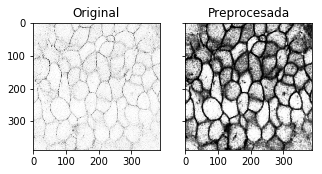

In [5]:
img_num=5
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharex=True, sharey=True)
ax[0].imshow(original[img_num], cmap=plt.cm.Greys_r)
ax[0].set_title('Original')
ax[1].imshow(preprocesada[img_num], cmap=plt.cm.Greys_r)
ax[1].set_title('Preprocesada')

Define dataset, aplica modelo y watershed

In [6]:
path="../pytorch-unet-segmentation-master/preprocesada"
claudio_loader= LoadDataset.loadData(path)
modelo= '../pytorch-unet-segmentation-master/modelos/model_epoch_440.pwf'
water = Postprocesamiento.postprocesing(claudio_loader, modelo)

Definir las salidas del modelo

In [7]:
image=water[0] #imagen con padd
output=water[1] #mascara binaria
img_list=water[2] #lista mascaras binarias
water_list=water[3] #lista imagens watershed
watershed=water[4] #funcion watershed

Muestra imagen con pad, imagen binarizada, y preprocesada

<IPython.core.display.Javascript object>


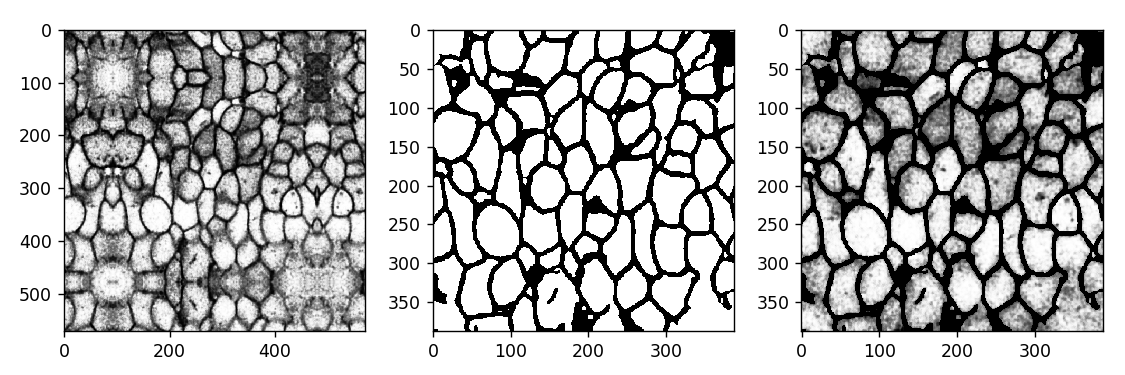

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
pad = (572-388)//2
ax[0].imshow(image.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output.numpy()[0], cmap=plt.cm.Greys_r)
borders_on_top = image.numpy()[0, 0, pad:-pad, pad:-pad].copy()
idx = np.where(output.numpy()[0].astype(int) == 0)
borders_on_top[idx[0], idx[1]] = 0
ax[2].imshow(borders_on_top, cmap=plt.cm.Greys_r)

Muestra dos ejemplos de imagen binarizada y watershed

<IPython.core.display.Javascript object>


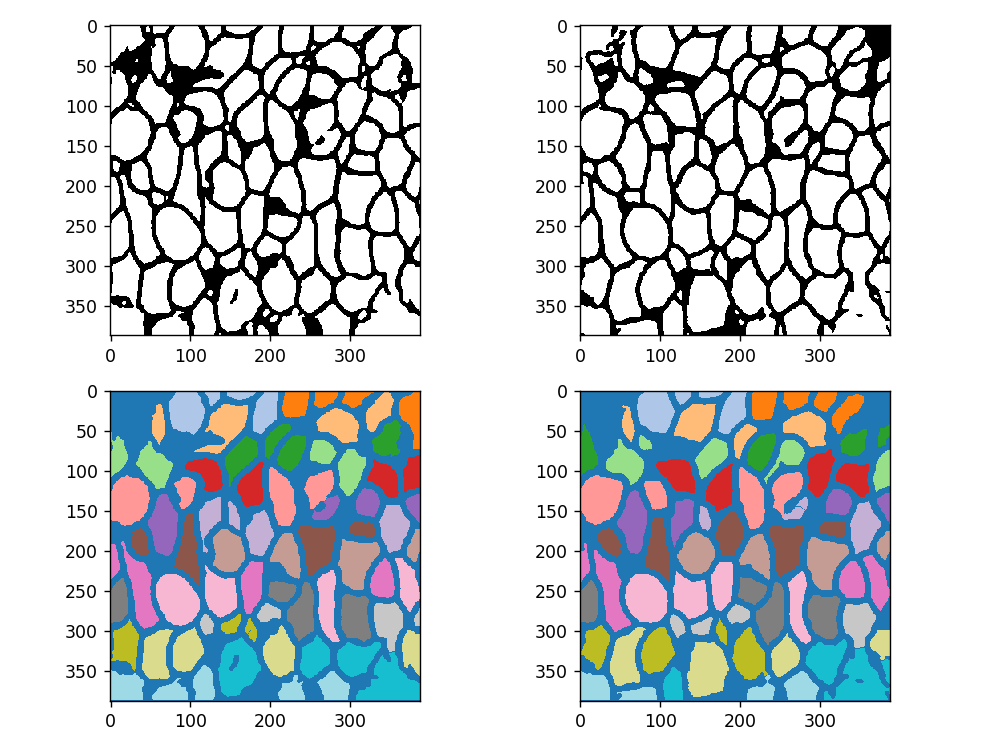

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0, 0].imshow(img_list[4], cmap=plt.cm.Greys_r)
ax[1, 0].imshow(water_list[4], cmap=plt.cm.tab20)
ax[0, 1].imshow(img_list[58], cmap=plt.cm.Greys_r)
ax[1, 1].imshow(water_list[58], cmap=plt.cm.tab20)

Escoger célula a trackear y aplicar vecinos mas cercanos

In [10]:
cell_idx = 40 #celula a trackear
tracking = Tracking.vecinosMasCercanos(watershed,water_list,cell_idx) 
cell_idx_history= tracking[0] #historia de posiciones de la celula
new_size_cell = tracking [1] #tamaño de la celula

Muestra grafico de area y animación de la célula

<IPython.core.display.Javascript object>


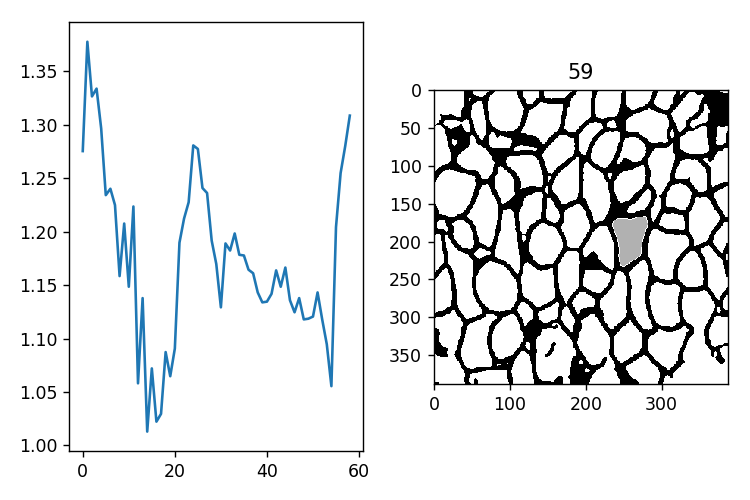

In [11]:
fig, ax = plt.subplots(1,2, figsize=(6, 4), tight_layout=True)
ax[0].plot(new_size_cell)

from matplotlib.animation import FuncAnimation

def update(k):
    ax[1].cla()
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 150
    ax[1].imshow(img, cmap=plt.cm.Greys_r)
    ax[1].set_title(k)
    
ani = FuncAnimation(fig, update, frames=range(60), repeat=False, interval=200)

Histograma imagen binarizada

<IPython.core.display.Javascript object>


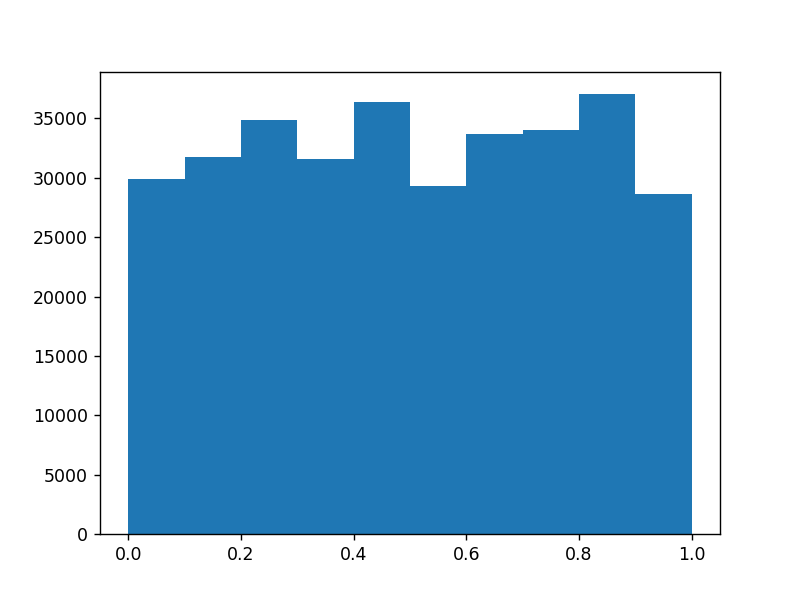

(array([29900., 31715., 34835., 31603., 36427., 29319., 33676., 34029.,
        37062., 28618.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

In [12]:
plt.figure()
plt.hist(image.numpy()[0, 0].ravel())